# MGMTMSA 408 Lecture 7: Location Models

In this notebook we will formulate the dock location problem as an integer programming problem. This problem is an example of a _facility location_ problem.

## Loading the data

The data we will use is stored in csv files, so we will first read it in using `pandas`.

In [2]:
# Load the pandas package.
import pandas as pd

# Load the list of customers 
customers_df = pd.read_csv('customer_loc.csv')

# Load the list of candidate locations 
stations_df = pd.read_csv('station_loc.csv')

# Load the distance matrix as a pandas data frame:
distance_df = pd.read_csv('station_customer_distances.csv')

In [3]:
# Let's examine the customers data frame:
customers_df.head()

,CustomerID,latitude,longitude
0,1,34.055417,-118.445924
1,2,34.066616,-118.454832
2,3,34.057416,-118.445048
3,4,34.067169,-118.427887
4,5,34.065696,-118.452859


In [4]:
# The stations data frame:
stations_df.head()

,StationID,latitude,longitude
0,1,34.057962,-118.425591
1,2,34.055398,-118.445166
2,3,34.062226,-118.442885
3,4,34.053204,-118.443139
4,5,34.054954,-118.444503


In [5]:
# Finally, the distance matrix data frame:
stations_df.head()

,StationID,latitude,longitude
0,1,34.057962,-118.425591
1,2,34.055398,-118.445166
2,3,34.062226,-118.442885
3,4,34.053204,-118.443139
4,5,34.054954,-118.444503


In [6]:
distance_df.tail()

,StationID,CustomerID,Time,Distance
14695,42,346,1128,1599
14696,42,347,1644,2363
14697,42,348,552,776
14698,42,349,563,778
14699,42,350,1952,2777


In [6]:
# Here is how we can access these:

# Access a single column:
distance_df['Time']

0        1844
1        2974
2        1817
3         999
4        2873
         ... 
14695    1128
14696    1644
14697     552
14698     563
14699    1952
Name: Time, Length: 14700, dtype: int64

In [7]:
# Access the first row (= row 0):
distance_df.iloc[0]

StationID        1
CustomerID       1
Time          1844
Distance      2371
Name: 0, dtype: int64

In [8]:
# Access rows 2 to row 7:
distance_df.iloc[2:7]

,StationID,CustomerID,Time,Distance
2,1,3,1817,2338
3,1,4,999,1222
4,1,5,2873,3694
5,1,6,1908,2445
6,1,7,1897,2412


In [9]:
# Get a summary of the columns:
distance_df.describe()

,StationID,CustomerID,Time,Distance
count,14700.000000,14700.000000,14700.000000,14700.000000
mean,21.500000,175.500000,1178.646463,1520.876259
std,12.121331,101.039321,661.111869,853.563406
min,1.000000,1.000000,0.000000,0.000000
25%,11.000000,88.000000,677.000000,873.000000
50%,21.500000,175.500000,1123.000000,1440.000000
75%,32.000000,263.000000,1619.000000,2088.000000
max,42.000000,350.000000,4097.000000,5087.000000


The data frame `distance_df` contains information for each candidate station location, and each customer. Specifically, it contains the travel time by foot (in seconds) from the station to the customer, and the distance (in meters) from the station to the customer. 

## Wrangling the data

To help us with formulating the problem, it will be helpful to reformat the data so that we can more easily use it. We will reshape the distance column in the distance_df so that we have a nice 2D matrix where rows are stations and columns are customers. 

We can do this with the numpy package, as follows:

In [10]:
#put customer id as columns

distance_df

,StationID,CustomerID,Time,Distance
0,1,1,1844,2371
1,1,2,2974,3816
2,1,3,1817,2338
3,1,4,999,1222
4,1,5,2873,3694
...,...,...,...,...
14695,42,346,1128,1599
14696,42,347,1644,2363
14697,42,348,552,776
14698,42,349,563,778


In [11]:
# Load numpy
import numpy as np


# First, let's get the number of customers and locations:
m = customers_df.shape[0] # shape[0] -> num. rows, shape[1] -> num. columns
n = stations_df.shape[0]

# Show how many locations and how many customers there are:
print(n)
print(m)

# Finally, access the 'Distance' column of distance_df and convert it
# to a numpy array.
distance_1d = np.array(distance_df['Distance'])

# Now we can create a matrix of distances for each (i,j) pair:
distance_2d = distance_1d.reshape(n, m)

# Let's check whether this worked: look at facility 0,...,2 , customers 0,...,5:
print("Test of distance_2d:")
print(distance_2d[0:3,0:6])

# Look inside the data frame:
distance_df.loc[ distance_df['CustomerID'].isin([1,2,3,4,5,6]) & distance_df['StationID'].isin([1,2,3]) ]

42
350
Test of distance_2d:
[[2371 3816 2338 1222 3694 2445]
 [  87 1565  317 2362 1443 1063]
 [1079 1489  706 1909 1301  153]]


,StationID,CustomerID,Time,Distance
0,1,1,1844,2371
1,1,2,2974,3816
2,1,3,1817,2338
3,1,4,999,1222
4,1,5,2873,3694
5,1,6,1908,2445
350,2,1,66,87
351,2,2,1247,1565
352,2,3,244,317
353,2,4,1867,2362


## Building our model

Now that we have set up the data, let's go ahead with building our model. 



In [12]:
from gurobipy import *

# Create the model.
m1 = Model()

# Create the variables.
# Notice that we supply the additional argument vtype = GRB.BINARY, 
# to indicate that these are binary variables.
x = m1.addVars(n, vtype = GRB.BINARY)
y = m1.addVars(n, m, vtype = GRB.BINARY)


# Add the constraints:
for j in range(m):
    m1.addConstr(sum(y[i,j] for i in range(n)) == 1) # each customer must be served
    for i in range(n):
        m1.addConstr(y[i,j] <= x[i]) # a customer j is served by location i only if location i is opened

# Add the constraint that we do not open more than five docking stations
m1.addConstr( sum(x[i] for i in range(n)) <= 5)

# Set the objective (minimize average walking distance for all customers)
m1.setObjective(1.0/m * sum( distance_2d[i,j] * y[i,j] for i in range(n) for j in range(m)), GRB.MINIMIZE)

# Solve the problem!
m1.update()
m1.optimize()

# Print the locations that we opened
locs = [i for i in range(n) if x[i].x > 0.5]
print(locs)

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[arm] - Darwin 23.2.0 23C71)

CPU model: Apple M1
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads



GurobiError: Model too large for size-limited license; visit https://www.gurobi.com/free-trial for a full license

## An alternate model

The model we came up with above is not the only model we can come up with. Let's take a look at a different model.

In [13]:
m2 = Model()

# Create the variables -- these are the same as before. 
x2 = m2.addVars(n, vtype = GRB.BINARY)
y2 = m2.addVars(n, m, vtype = GRB.BINARY)

# Create the constraints. 
# Every customer is served from exactly one location:
for j in range(m):
    m2.addConstr(sum(y2[i,j] for i in range(n)) == 1)

# A customer is only served from location i if location i is opened:
for i in range(n):
    m2.addConstr( sum(y2[i,j] for j in range(m)) <= m * x2[i])

# Add the constraint that we do not open more than 5 docking stations
m2.addConstr( sum(x2[i] for i in range(n)) <= 5)

# Set the objective 
m2.setObjective(1.0/m * sum( distance_2d[i,j] * y2[i,j] for i in range(n) for j in range(m)), GRB.MINIMIZE)

# Solve the problem!
m2.update()
m2.optimize()

# Output which stations were opened!
locs2 = [i for i in range(n) if x2[i].x > 0.5]
print(locs2)

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[arm] - Darwin 23.2.0 23C71)

CPU model: Apple M1
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads



GurobiError: Model too large for size-limited license; visit https://www.gurobi.com/free-trial for a full license

Notice that the solution log looks a bit different!

We can actually explicitly compare the solution times:

In [13]:
print("Model 1 run time: ", m1.runtime)
print("Model 2 run time: ", m2.runtime)

Model 1 run time:  0.21820688247680664
Model 2 run time:  3.161005973815918


It appears (at least on my system) that model 1 solved a bit faster. Why is this?

## Solving the relaxation

The linear programming relaxation of an integer program is the linear program that we get by "relaxing" all binary variables to be continuous. In other words, any constraint of the form 
\begin{equation}
x_i \in \{0,1\}
\end{equation}
is replaced with 
\begin{equation}
0 \leq x_i \leq 1.
\end{equation}

Solving the relaxation is useful because it provides us with a bound on the optimal value. In this case, since we are solving a minimization problem, the optimal value of the LP relaxation will be a lower bound on the optimal value of the integer program. (If we were solving a maximization problem, the optimal value of the relaxation would analogously be an upper bound.)

Solving the relaxation is also useful because it gives us a simple way of comparing formulations, besides directly solving them. If formulation A is stronger than formulation B, then the bound from A should be at least as good as the bound from B.

Concretely: if the problem is a minimization problem, $Z_A$ and $Z_B$ are the relaxation bounds for formulations A and B, and $Z^*$ is the optimal value of the integer program, then we will have:

\begin{equation}
Z_B \leq Z_A \leq Z^*.
\end{equation}

To solve the LP relaxations of the two models we have seen so far, we could create them from scratch, leave out the "vtype = GRB.BINARY" argument in m.addVars, and make sure to put lower and upper bounds on the variables so that they are bounded between 0 and 1. Fortunately, it turns out Gurobi gives us an easier way to access the relaxation:

In [14]:
# Use the relax() command to get the LP relaxation:

r1 = m1.relax()
r2 = m2.relax()

# r and r2 are new Gurobi models that are linear programs.
# We can now invoke their optimize() methods to solve each one.

r1.optimize()

r2.optimize()

relax1_obj = r1.objval
relax2_obj = r2.objval

print()
print()
print("Relaxation 1 objective :", relax1_obj)
print("Relaxation 2 objective :", relax2_obj)
print("Integer optimal objective :", m1.objval)

Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[rosetta2])

CPU model: Apple M1 Max
Thread count: 10 physical cores, 10 logical processors, using up to 10 threads

Optimize a model with 15051 rows, 14742 columns and 44142 nonzeros
Model fingerprint: 0xe0e7328a
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [6e-03, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 5e+00]
Presolve time: 0.02s
Presolved: 15051 rows, 14742 columns, 44142 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 42
 AA' NZ     : 2.944e+04
 Factor NZ  : 6.406e+04 (roughly 13 MB of memory)
 Factor Ops : 1.210e+06 (less than 1 second per iteration)
 Threads    : 8

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   1.72038165e+04 -1.83243652e+02  1.03e+01 0.00e+00  8.57e-0

Notice that the first relaxation has an optimal objective of 454.64 (meters), whereas the second relaxation has an optimal objective of 232.76 (meters). Notice that the first value is actually exactly equal to the integer optimal value, while the second is significantly smaller. In general for a minimization problem, the optimal value of a relaxation will be less than or equal to the optimal value for the integer problem.

## Understanding the solution

Finally, let's try to see what the solution looks like. This section of the notebook will serve as a brief introduction to Folium, which is a package in Python for plotting on maps. 

(This part requires Folium to be installed; on my Anaconda installation, it was not included by default. To install it, you can run the following command in your terminal/Anaconda prompt:

    conda install -c conda-forge folium

It will take a little bit of time to run.)

As it turns out, the locations we are using are real locations. Let's see where we are. The code below will find the average latitude/longitude of the customers, and plot a map zoomed in on that average location.


In [15]:
import folium

# Figure out where the "center" of the plot should be
avg_lat = customers_df['latitude'].mean()
avg_lon = customers_df['longitude'].mean()

# Let's create the map
dockmap = folium.Map(location=[avg_lat, avg_lon], 
                  zoom_start = 15, detect_retina = True)
dockmap

It should (hopefully!) look familiar to you!

Folium is a very flexible package, and it allows us to plot all sorts of markers. Let's start by plotting the customer locations.

In [16]:
# Let's add the customer locations, as well as the dock locations that we selected.
tooltip_customer_location = 'Customer location'
for i in range(customers_df.shape[0]):
    folium.CircleMarker([customers_df['latitude'][i], customers_df['longitude'][i]], 
                        popup='Customer',
                        radius = 5,
                        color = 'blue',
                        fill = True,
                        fillcolor = 'blue',
                        tooltip=tooltip_customer_location).add_to(dockmap)
dockmap

Lastly, let's plot the solution. Similarly to customers_df, facilities_df includes latitudes and longitudes for each dock location.

The code below will plot all of the docks. The docks that are used will appear in green, while the ones that are not used will appear in red.

In [17]:
# Finally, let's add the docks. 
# To do this, let's first extract which locations were actually used in the optimal solution:
docks_used = [i for i in range(n) if x[i].x > 0.5]

# Let's also calculate how many customers are served by 
# each dock.
served_by_each_dock = dict()
for i in docks_used:
    served_by_each_dock[i] = sum( [ y[i,j].x for j in range(m)] )

# Finally, let's add the docks.
tooltip_dock_opened = 'Dock (opened)'
tooltip_dock_notopened = 'Dock (not opened)'    
for i in range(n):
    if i in docks_used:
        folium.Marker([stations_df['latitude'][i], stations_df['longitude'][i]], 
                  popup='Dock serving ' + str(int(served_by_each_dock[i])) + " customers",
                  icon = folium.Icon(color = 'green', icon = 'none'),
                  tooltip=tooltip_dock_opened).add_to(dockmap)
    else:
        folium.CircleMarker([stations_df['latitude'][i], stations_df['longitude'][i]], 
                    radius = 5,
                    color = 'red',
                    fill = True,
                    fillcolor = 'red',
                    tooltip=tooltip_dock_notopened).add_to(dockmap)

dockmap


Try clicking on one of the green icons!

## Maximum coverage location problem

The problem we examined earlier is an example of a problem known as the _$p$-median problem_. In the general $p$-median problem, we have to open $p$ facilities to serve a set of $m$ customers at the lowest cost. The cost of serving a customer is based on the facility location to which they are assigned to. In our dock station model, the cost of serving customer $j$ from location $i$ is modeled as $d_{i,j} \, / \, m$. In this way the overall objective models the average of the distance of any customer from its closest station. 

An alternate way of approaching location problems is rather than minimizing cost (or in our case distance), to maximize coverage. Coverage refers to the number of customers who are within a certain distance of the nearest location to them. One such model is the maximal coverage location problem (MCLP). The MCLP seeks to decide which locations to open, so that the number of customers who are within a certain distance of their nearest location is maximized, while ensuring that the number of locations opened is equal to some predefined number. 

The code below formulates the MCLP, assuming that a location "covers" a customer if the customer is within 400 meters of that location.

In [18]:
# Create the a matrix (a_mat) below.
coverage_distance = 400
a_mat = np.asarray( [ [int(distance_2d[i,j]<coverage_distance) for j in range(m)] for i in range(n)])
print(a_mat.shape)

# Create the Gurobi model. 
m_MCLP = Model()

x = m_MCLP.addVars(n, vtype = GRB.BINARY)
z = m_MCLP.addVars(m, vtype = GRB.BINARY)

# Create coverage constraints: 
# if z[j] is 1 then for at least one i that covers j, x[i] must be equal to 1.
for j in range(m):
    m_MCLP.addConstr( z[j] <= sum( a_mat[i,j] * x[i] for i in range(n)) )

# Create the constraint that we open exactly 5 locations.
# (Create a constraint reference to this constraint, as we will vary the right-hand
# side shortly.)
p_constr = m_MCLP.addConstr( sum(x[i] for i in range(n)) == 5) 


m_MCLP.setObjective( sum(z[j] for j in range(m) ), GRB.MAXIMIZE)

m_MCLP.update()
m_MCLP.optimize()

(42, 350)
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[rosetta2])

CPU model: Apple M1 Max
Thread count: 10 physical cores, 10 logical processors, using up to 10 threads

Optimize a model with 351 rows, 392 columns and 1640 nonzeros
Model fingerprint: 0x90f4d340
Variable types: 0 continuous, 392 integer (392 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e+00, 5e+00]
Found heuristic solution: objective 110.0000000
Presolve removed 276 rows and 277 columns
Presolve time: 0.00s
Presolved: 75 rows, 115 columns, 505 nonzeros
Variable types: 0 continuous, 115 integer (114 binary)
Found heuristic solution: objective 148.0000000

Root relaxation: objective 1.970000e+02, 56 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     

We can also visualize this solution with Folium, using the code below.

In [19]:
dockmap = folium.Map(location=[avg_lat, avg_lon], 
                  zoom_start = 15, detect_retina = True)

customers_covered = [j for j in range(m) if z[j].x > 0.5]

for j in range(m):
    if (j in customers_covered):
        folium.CircleMarker([customers_df['latitude'][j], customers_df['longitude'][j]], 
                            radius = 5,
                            color = 'blue',
                            fill = True,
                            fillcolor = 'blue',
                            tooltip='Customer ' + str(j) + ' - covered').add_to(dockmap)
    else:
        folium.CircleMarker([customers_df['latitude'][j], customers_df['longitude'][j]], 
                            radius = 5,
                            color = 'purple',
                            fill = True,
                            fillcolor = 'purple',
                            tooltip='Customer ' + str(j) + ' - not covered').add_to(dockmap)
    
docks_used = [i for i in range(n) if x[i].x > 0.5]

# Finally, let's add the docks.
tooltip_dock_opened = 'Dock (opened)'
tooltip_dock_notopened = 'Dock (not opened)'    
for i in range(n):
    if i in docks_used:
        folium.Marker([stations_df['latitude'][i], stations_df['longitude'][i]], 
                  icon = folium.Icon(color = 'green', icon = 'none'),
                  tooltip=tooltip_dock_opened).add_to(dockmap)
    else:
        folium.CircleMarker([stations_df['latitude'][i], stations_df['longitude'][i]], 
                    radius = 5,
                    color = 'red',
                    fill = True,
                    fillcolor = 'red',
                    tooltip=tooltip_dock_notopened).add_to(dockmap)

dockmap

Remember that this MCLP instance seeks to maximize the number of customers who are within 400 meters of the closest dock station, subject to the constraint that exactly 5 stations are opened. In this example, the stations that are opened are generally those that are within dense customer locations (e.g., the one on Veteran, one on Rochester & Midvale).  Areas that are sparser in customers (e.g., the area between Santa Monica Blvd and Wilshire west of Westwood Blvd) are not served. With only 5 stations that can be added, it makes sense that the best solution will be one that prioritizes such dense locations. 

An interesting question to ask is how the coverage might change as we modify the number of locations that we open. The code below plots a trade-off curve of $p$ and the number of customers who are covered. 

p =  0 , coverage =  -0.0
p =  1 , coverage =  63.0
p =  2 , coverage =  109.0
p =  3 , coverage =  153.0
p =  4 , coverage =  180.0
p =  5 , coverage =  197.0
p =  6 , coverage =  214.0
p =  7 , coverage =  229.0
p =  8 , coverage =  243.0
p =  9 , coverage =  255.0
p =  10 , coverage =  265.0
p =  11 , coverage =  275.0
p =  12 , coverage =  282.0
p =  13 , coverage =  289.0
p =  14 , coverage =  294.0
p =  15 , coverage =  298.0
p =  16 , coverage =  301.0
p =  17 , coverage =  304.0
p =  18 , coverage =  306.0
p =  19 , coverage =  307.0
p =  20 , coverage =  308.0
p =  21 , coverage =  309.0
p =  22 , coverage =  310.0
p =  23 , coverage =  310.0
p =  24 , coverage =  310.0
p =  25 , coverage =  310.0
p =  26 , coverage =  310.0
p =  27 , coverage =  310.0
p =  28 , coverage =  310.0
p =  29 , coverage =  310.0
p =  30 , coverage =  310.0
p =  31 , coverage =  310.0
p =  32 , coverage =  310.0
p =  33 , coverage =  310.0
p =  34 , coverage =  310.0
p =  35 , coverage =  310.0
p = 

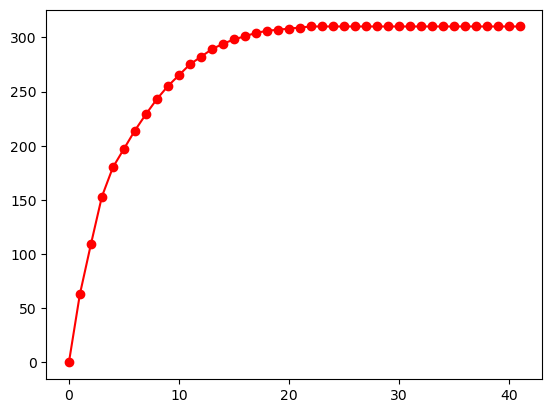

In [20]:
m_MCLP.params.OutputFlag = 0

obj_list = np.zeros(n)
p_list = list(range(n))

for p in p_list:
    p_constr.rhs = int(p)
    m_MCLP.update()
    m_MCLP.optimize()
    obj_list[p] = m_MCLP.objval
    print('p = ', p_list[p], ', coverage = ', obj_list[p])

    

import matplotlib.pyplot as plt
plt.plot(p_list, obj_list, 'ro-', )

In [ ]:
a_mat.shape
# there are 350 customers but we plateau at 310 customers
# this is because no matter what location we open
# some customers are always more than 400 meters away

In these types of problems, we often face a trade-off between the number of locations that we open and the coverage we obtain -- to obtain higher coverage, we must open more locations which would translate to greater costs. The plot above shows that there is a rapid increase in coverage as we go from 0 to 10 stations; from 10 to 15 this improvement slows down; and from 15 stations onward there is a very modest improvement in coverage. Note that the curve maxes out at 310 customers; this is because some customers are more than 400 meters away from all of the 42 candidate locations.

Plotting this type of relationship is useful when the number of locations that must be opened (in this case 5) is a number that is not set in stone, but one is interested in knowing the number of locations at which one faces diminishing returns. 

## $p$-Center Problem

The last type of location problem that we will consider is the $p$-center problem. The $p$-center problem is similar to the $p$-median problem, but with a slightly different objective. Recall that the $p$-median problem seeks to open $p$ locations so that the average distance of each customer from its closest location is minimized. The $p$-center problem seeks to open $p$ location so that the largest distance of any customer from their closest location is minimized. 

The code below formulates the $p$-center problem.

In [21]:
m_pc = Model()

x = m_pc.addVars(n, vtype = GRB.BINARY)
y = m_pc.addVars(n,m, vtype = GRB.BINARY)
r = m_pc.addVar()


# Add the constraints:
for j in range(m):
    m_pc.addConstr(sum(y[i,j] for i in range(n)) == 1) # each customer must be served
    for i in range(n):
        m_pc.addConstr(y[i,j] <= x[i]) # a customer j is served by location i only if location i is opened
    
    m_pc.addConstr(r >= sum( distance_2d[i,j] * y[i,j] for i in range(n)))

# Add the constraint that we do not open more than five docking stations
m_pc.addConstr( sum(x[i] for i in range(n)) <= 5)

# Set the objective (minimize average walking distance for all customers)
m_pc.setObjective(r, GRB.MINIMIZE)

# Solve the problem!
m_pc.update()
m_pc.optimize()



Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[rosetta2])

CPU model: Apple M1 Max
Thread count: 10 physical cores, 10 logical processors, using up to 10 threads

Optimize a model with 15401 rows, 14743 columns and 59187 nonzeros
Model fingerprint: 0xb7762198
Variable types: 1 continuous, 14742 integer (14742 binary)
Coefficient statistics:
  Matrix range     [1e+00, 5e+03]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 5e+00]
Presolve time: 0.10s
Presolved: 15401 rows, 14743 columns, 52296 nonzeros
Variable types: 0 continuous, 14743 integer (14742 binary)
Found heuristic solution: objective 2795.0000000
Found heuristic solution: objective 2788.0000000
Found heuristic solution: objective 2746.0000000

Root relaxation: objective 1.371000e+03, 2488 iterations, 0.06 seconds (0.11 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/N

Let us visualize the solution below using Folium. 

In [22]:
# Let's create the map
dockmap = folium.Map(location=[avg_lat, avg_lon], 
                  zoom_start = 15, detect_retina = True)

# Add customers. Code below will show which station serves
# each customer, and what the distance is to that station.
tooltip_customer_location = 'Customer location'
for j in range(m):
    temp = [i for i in range(n) if y[i,j].x > 0.5]
    i2 = temp[0]
    served_by_dist = distance_2d[i2,j]
    folium.CircleMarker([customers_df['latitude'][j], customers_df['longitude'][j]], 
                        popup='Customer - served by ' + str(i2) + ', dist = ' + str(served_by_dist),
                        radius = 5,
                        color = 'blue',
                        fill = True,
                        fillcolor = 'blue',
                        tooltip=tooltip_customer_location).add_to(dockmap)

docks_used = [i for i in range(n) if x[i].x > 0.5]

# How many customers 
served_by_each_dock = dict()
for i in docks_used:
    served_by_each_dock[i] = sum( [ y[i,j].x for j in range(m)] )

# Add the dock stations.
# (Note: code below also displays station ID)
tooltip_dock_opened = 'Dock (opened)'
tooltip_dock_notopened = 'Dock (not opened)'    
for i in range(n):
    if i in docks_used:
        folium.Marker([stations_df['latitude'][i], stations_df['longitude'][i]], 
                  popup='Dock ' + str(i) + ' serving ' + str(int(served_by_each_dock[i])) + " customers",
                  icon = folium.Icon(color = 'green', icon = 'none'),
                  tooltip=tooltip_dock_opened).add_to(dockmap)
    else:
        folium.CircleMarker([stations_df['latitude'][i], stations_df['longitude'][i]], 
                    radius = 5,
                    color = 'red',
                    fill = True,
                    fillcolor = 'red',
                    tooltip=tooltip_dock_notopened).add_to(dockmap)

dockmap

Notice that this solution, while similar in some respects to the earlier $p$-median solution we saw, is quite a bit different. Whereas the previous solution placed stations in dense areas, this solution spreads out the stations more to ensure that no customer is too far from a station. This is because the objective function measures the highest distance of any customer from the station that it serves. For the objective function to be large, all it takes is for one customer to be far away from one of the stations to be open. Thus, the $p$-center problem essentially tries to select station locations with the worst-off customer in mind. 

Most interestingly, there is one station that is placed near the intersection of Beverly Glen and Sunset Blvd. This is because there are a handful of customers who are in the vicinity of that station, and that station is the only station that is relatively near to those customers. Without that station, those customers would need to be served by some station that would be much further away (e.g., west of campus, or near Wilshire and Beverly Glen), which would lead to a much higher objective value. 

**Question**: Click on the green icons above to see how many customers are served by each station. What do you notice about the stations selected here, compared to the $p$-median solution?